<a href="https://colab.research.google.com/github/yavuzuzun/projects/blob/main/Lab2_ECE442.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This notebook is a Homework prepared for thr ECE 442 Network Science Analytics class taught by Gonzalo Mateos during Spring 2023
## Descriptive analysis of network graph characteristics
In this second laboratory we will re-examine some of the structural properties of large-scale networks we discussed in class (for instance, power-law degree distributions and assortative mixing). In particular, we will corroborrate that these properties indeed arise with some real-world networks encountered across diverse domains. Moreover, we will implement a few of the classic spectral-based algorithms for graph partitioning or network community detection. Various metrics to assess performance of these unsupervised node clustering algorithms will be introduced, which we will bring to bear in our experiments with the workhorse Zachary's Karate Club network and a political blog graph from the 2004 US presidential election.

In [ ]:
# load graspologic. This is a library that will be quite helpful in the following
# laboratory on Models for network graphs and their applications. For now, we will
# just leverage one of the useful methods it provides.
# before that we load prior versions of scipy, networkx and gensim because those
# that come with Colab are not compatible with graspologic (this will be fixed soon)
!pip install --upgrade scipy
!pip install networkx==2.8.5
!pip install gensim==4.2.0
!pip install psutil==5.9.4
!pip install graspologic==2.0.0

In [ ]:
# import PyTorch
import torch

In [ ]:
# install PyG for the working version of PyTorch
!pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-geometric

##IMPORTANT: Restart runtime
After installing the libraries in the cells above, you must restart Colab's runtime (go to Runtime --> Restart runtime or Ctrl+M). Otherwise, you will an error in the cell that follows. 

In [ ]:
# load the libraries we will use
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import torch
# load that specific method from graspologic I want to use later on
from graspologic.utils import remap_labels

## Structural properties of large-scale networks

### Degree distribution
In this section we will examine the degree distribtion of a real network, constructed from citation data among machine learning papers. Given an undirected graph $G$, let $P(d)$ denote the fraction of vertices in the graph with degree $d$. The collection $\{P(d)\}_{d\geq 0}$ is the *degree distribution of graph $G$*. For example, in the toy graph depicted below:

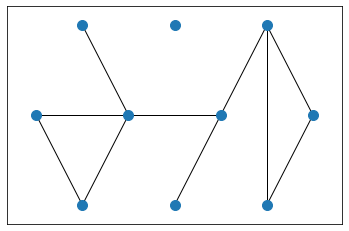

the degree distribution is $P(0) = 1/10$, $P(1) = 2/10$, $P(2) = 4/10$, $P(3) = 2/10$, $P(4) = 1/10$ and $P(d) = 0$ for all $d>4$. From the example it should be clear that for graphs with a finite number of vertices, then the degree distribution must satisfy $P(d)=0$ for all degrees exceeding some maximum value.

Note that the degree distirbution can be obtained as the normalized histogram constructed from the graph's degree sequence, using histogram *bins* of size one that are centered on the non-negative integers. 

1. Write a function that computes the degree distribution of a graph given its degree sequence. The function [`numpy.histogram`](https://numpy.org/doc/stable/reference/generated/numpy.histogram.html) may be useful to that end. A list of nodal degrees should be sufficient as input to the method, it does not need to be ordered as in the definition of degree sequence used in class.  

In [ ]:
def degree_distribution(degree_sequence):
  # TODO: Implement this function that takes the graph's degree sequence as input
  # and returns its degree distribution

  ############# your code here #############
  
  maxN = np.max(degree_sequence)
  binS = np.linspace(-0.5,maxN+0.5,num=maxN+2) # create bins

  degree_distribution = np.histogram(degree_sequence,binS)

  degree_distribution = degree_distribution[0].tolist()
  degree_distribution = degree_distribution/np.sum(degree_distribution)

  #########################################

  return degree_distribution

In [ ]:
# let's test that the function gives the right answer for the toy graph above
# build the graph from the edge list
G = nx.Graph()
nodelist = np.arange(1,11)
G.add_nodes_from(nodelist)
edgelist = [(1,2), (1,3), (2,3), (3,4), (3,6), (6,7), (6,8), (8,9), (8,10), (9,10)]
G.add_edges_from(edgelist)

# fix the vertex positions
dx = 0.5
dy = 0.5
pos = {1:(0,0),2:(dx,-dy),3:(2*dx,0),4:(dx,dx),5:(3*dx,dy),6:(4*dx,0),7:(3*dx,-dy),8:(5*dx,dy),9:(5*dx,-dy),10:(6*dx,0)}
# draw the graph
plt.figure()
plt.title('Graph from the example')
nx.draw_networkx(G,pos=pos,with_labels=False,node_size=100)

# compile the degree sequence
degree_list = [deg for (node,deg) in G.degree()]
degree_dist = degree_distribution(degree_list)
print(f'The degree distribution of the toy graph is {degree_dist}')

### Power-law distributions and scale-free networks
We say that a degree distribution obeys a *power law* if $P(d) = Cd^{-\alpha}$. In practice, the degree distribution of several real-world networks across various domains follows a power law. In this part of the laboratory, we will work with a network of citations among machine learning papers. Data come from the paper [Automating the Construction of Internet Portals with Machine Learning](https://link.springer.com/article/10.1023/A:1009953814988). We will consider an undirected version of the graph, where vertices correspond to papers and if paper $i$ cites paper $j$ (or viceversa), then there is an edge joining $i$ and $j$. Each vertex in this graph is assigned to one of seven classes according to the paper's topic. In other words, nodes are labeled. 

In [ ]:
# load the dataset, which is conveniently included in PyG
from torch_geometric.datasets import Planetoid

cora_dataset = Planetoid(root='/tmp/cora', name='Cora')

In [ ]:
# some dataset characteristics
print(f'Dataset: {cora_dataset}:')
print('======================')
print(f'Number of graphs: {len(cora_dataset)}')
print(f'Number of classes: {cora_dataset.num_classes}')

In [ ]:
# let's focus on the first graph
cora_data = cora_dataset[0]

print(cora_data)
print('==============================================================')

# some descritptive graph characteristics
print(f'Number of nodes: {cora_data.num_nodes}')
print(f'Number of edges: {cora_data.num_edges}')
print(f'Average node degree: {(2*cora_data.num_edges) / cora_data.num_nodes:.2f}')
print(f'Graph has isolated nodes: {cora_data.has_isolated_nodes()}')
print(f'Graph has self loops: {cora_data.has_self_loops()}')
print(f'Graph is undirected: {cora_data.is_undirected()}')

In [ ]:
# visualize the graph
from torch_geometric.utils import to_networkx

G_cora = to_networkx(cora_data)
plt.figure(figsize=(12,12))
cora_pos = nx.spring_layout(G_cora, seed=20)
nx.draw_networkx(G_cora,node_color=cora_data.y,pos=cora_pos,with_labels=False)

The goal of this part is to assess whether the degree distribution of the citation network follows a power law. To that end, notice that a logarithmic transformation applied to both sides of the equality $P(d) = Cd^{-\alpha}$ yields $\log P(d) = -\alpha \log d + \tilde{C}$. Accordinlgy, if a power-law degree distribution is tenable then we expect to see a linear relationship between $P(d)$ and $d$ when *plotted in log-log scale*.

2. Plot the degree distribution $P(d)$ versus $d$ in log-log scale. Would you say the degree distribution obeys a power law? Discuss.

In [ ]:
# compute the degree distribution for the citation network 
deg_sequence = np.array([deg for (node, deg) in G_cora.degree()])

deg_distribution = degree_distribution(deg_sequence)

# TODO: plot the degree distribution P(d) versus d in log-log scale

############# your code here #############
  
plt.figure(figsize=(9,7))
plt.title('CORA Dataset, Degree Distribution', fontsize=20)
plt.xlabel('d', fontsize=16)
plt.ylabel('P(d))', fontsize=16)

plt.plot(np.arange(np.size(deg_distribution)),deg_distribution.transpose())
plt.yscale('log')
plt.xscale('log')
plt.grid(True)

#########################################

## Evaluation of the result
It is hard to assess the linearity of the distribution with the binning we made. When we move from low d to high d, we encounter exponentially more bins in equal distance, since we are in log-scale. This makes it harder to interpret high d bins since they are naturally more rare and noisy. However, the middle part of the distribution, between (5, 50), seem to obey power law.

In practice, it is rarely the case that power-law degree distributions are followed over the entire range of degrees. What typically happens instead is that we observe a good fit for large values of $d$, namely in the tail of the distribution. So in general, when we say degrees in a network obey a power-law distribution, we mean the property holds over some suitable range of the entire support. As discussed in class, said networks are often dubbed *scale-free*.

In your plot of the citation network's degree distribution you should see large fluctuations for high degree values, which could hinder our ability to asses whether a power law is tenable here. The reason for this *tail noise* is that for large values of $d$, there are very few nodes with said degrees. Hence, each of the corresponding histogram bins will accrue very limited counts, explaining the high-degree fluctuations you observe. One possible workaround would be to widen the bins in the tail of the histogram so that each of them collects more samples. However, uniformly increasing the bin widths over the whole support will sacrifice the resolution of the histogram for small degree values. A good solution is thus to employ bins that are *equispaced in logarithmic scale*, an approach known as logarithmic binning.


3. Plot a histogram for the degrees of the citation network using bins of width $2^n$, for $n=0,1,2, \dots$ (that is, equispaced in logarithmic scale). Do you still stand by your answer to Question 2.? ¿Sigue manteniendo la misma respuesta que en la parte 2.? Are you more certain now as to whether the citation network can be characterized as scale-free?

In [ ]:
# TODO: plot a histogram for the degrees of the citation network using
# using logarithmic binning

############# your code here #############

def degree_distribution_binOpt(degree_sequence,binning):
  # TODO: Implement this function that takes the graph's degree sequence as input
  # and returns its degree distribution
  
  if binning == 'log':
    maxN = np.ceil(np.log2(np.max(degree_sequence)))
    binS = 2**(np.linspace(-1, maxN, num=int(maxN+2))+0.1)
  elif binning == 'linear':
    maxN = np.max(degree_sequence)
    binS = np.linspace(-0.5,maxN+0.5,num=maxN+2) # no given binning, assign linear binning
  else:
    print('Invalid binning option. Binning can be either "log" or "linear".')
    return

  degree_distribution = np.histogram(degree_sequence,binS)

  degree_distribution = degree_distribution[0].tolist()
  degree_distribution = degree_distribution #/np.sum(degree_distribution)

  return degree_distribution, binS

deg_distribution, bin_val = degree_distribution_binOpt(deg_sequence,'log')
  
plt.figure(figsize=(9,7))
plt.title('CORA Dataset, Degree Distribution (log-log)', fontsize=20)
plt.xlabel('d', fontsize=16)
plt.ylabel('P(d))', fontsize=16)

plt.plot(bin_val[0:-1]*(2**(1/2)),deg_distribution)
plt.yscale('log')
plt.xscale('log')
plt.grid(True)

#########################################

## Evaluation of the resulting figure
Changing bin size made it clear that the tail region of the distribution also behaving linearly in the log-log scale. Distribution obeys power law. 

### Pareto distribution and estimation of the power-law exponent $\alpha$
With the aforementioned histogram construction you should observe a degree distribution that appears to follow a power law, at least for degree values exceeding some lower bound $d_\text{min}$. To characterize this behaviour and carry out statistical inference, we will model the observed degrees using the [Pareto distribution](https://en.wikipedia.org/wiki/Pareto_distribution). A continuous random variable $D$ has the Pareto distribution if its probability density function (pdf) is given by:

$$p(d) = \left\lbrace \begin{array}{c c} C d^{-\alpha} & \text{ if } d\geq d_\text{min} \\ 0 & \text{ otherwise} \end{array}\right.$$

4. Determine the value of the constant $C$ so that $p(d)$ is a valid pdf.

Consider now the important statistical inference task of estimating the power-law exponent $\alpha$. Given $n$ independent and identically distributed (i.i.d.) degree observations $d_1,\dots,d_{n}$ from a Pareto distribution, it is not hard to show (see the optional exercise at the end of the laboratory) that the maximum-likelihood estimator (MLE) of $\alpha$ is given by:

$$\hat{\alpha} = 1 +  \left[\frac{1}{n}\sum_{i=1}^{n} \log \left(\frac{d_i}{d_\text{min}}\right)\right]^{-1}.$$

5. Write a function that implements the aforementioned MLE, given the degree sequence and $d_{\min}$ as inputs. Estimate the power-law exponent for the citation network.

In [ ]:
def alpha_maximum_likelihood(deg_sequence, d_min):
  # TODO: Implement this function that takes the graph's degree sequence and 
  # the degree lower bound (from which a power law is credible) as inputs, and
  # returns the MLE of α

  # alpha always greater than 1, for pdf to be normalizable
  # alpha_hat = 0

  ############# your code here #############

  deg_distribution, bin_val = degree_distribution_binOpt(deg_sequence,'log')

  log_bin_centers = (bin_val[:-1] + bin_val[1:]) / 2

  deg_distribution = np.asarray(deg_distribution)
  deg_distribution = deg_distribution[log_bin_centers > d_min]
  n = np.size(deg_distribution)
  log_weighted_degree = np.sum(np.log(deg_distribution/d_min))
  alpha_hat = 1 + n / log_weighted_degree
  
  #########################################

  return alpha_hat



Let's compute $\hat{\alpha}$ for the citation network. If your implementation of the MLE is correct, then you should obtain a value that is around $4$.

In [ ]:
d_min = 10
alpha_hat_cora = alpha_maximum_likelihood(deg_sequence, d_min)

print(f"The estimated value of α for the paper citation network is {alpha_hat_cora:.3f}" )

### Assortative mixing and the modularity coefficient

In social networks, the notion of [*homophily*](https://en.wikipedia.org/wiki/Homophily) refers to the tendency of actors in the network towards selectively establishing ties with other actors that are similar in some context-dependent sense (i.e., "birds of a feather flock together"). In Network Science lingo, this tendency is often dubbed *assortative mixing*.

When vertices are labeled with categorical attributes or classes, a natural measure of assortativity is to quantify the fraction of edges in the network joining vertices in the same class. To fix ideas, suppose that each vertex belongs to one of $N_c$ classes (that is, each vertex $i$ has an attribute or label $c_i\in \{1,\dots,N_c\}$ indicating its membership to one of the $N_c$ classes). A metric to quantify the level of homophily or assortativity in a network is known as *modularity*, and is defined as:

$$Q = \frac{1}{2N_E} \sum_{i,j\in V} \left(A_{ij} -\frac{d_id_j}{2N_E} \right)\delta(c_i,c_j),$$

where $N_E$ is the number of edges in the graph, $A_{ij}$ denotes the $(i,j)$th entry of the adjacency matrix, $d_i$ is the degree of vertix $i$, and $\delta(r,p)$ stands for the Kronecker delta: $\delta(r,p) = 1$ if $r=p$ and $\delta(r,p) = 0$ if $r\neq p$. The modularity coefficient $Q$ compares the fraction of edges in the observed graph that join vertices from the same class against what would be obtained if the edges where assigned at random (while preserving the degree distribution of the original graph). The modularity coefficient $Q$ is strictly less than 1, it takes on positive values if edges predominantly join vertices of the same class, and negative values otherwise.

In this part of the laboratory we will compute the modularity coefficient for the citation network as well as for another network graph constructed from commercial airline flights within the US.

In [ ]:
# same as usual, import the dataset from PyG
from torch_geometric.datasets import Airports

airports_dataset = Airports(root='/tmp/airports', name='USA')

In [ ]:
# some dataset characteristics
print(f'Dataset: {airports_dataset}:')
print('======================')
print(f'Number of graphs: {len(airports_dataset)}')
print(f'Number of classes: {airports_dataset.num_classes}')

In [ ]:
# let's focus on the first graph
airports_data = airports_dataset[0]

print(airports_data)
print('==============================================================')

# some descritptive graph characteristics
print(f'Number of nodes: {airports_data.num_nodes}')
print(f'Number of edges: {airports_data.num_edges}')
print(f'Average node degree: {(2*airports_data.num_edges) / airports_data.num_nodes:.2f}')
print(f'Graph has isolated nodes: {airports_data.has_isolated_nodes()}')
print(f'Graph has self loops: {airports_data.has_self_loops()}')
print(f'Graph is undirected: {airports_data.is_undirected()}')

Flight data used to construct the graph come from the paper [struc2vec: Learning Node Representations from Structural Identity](https://arxiv.org/pdf/1704.03165.pdf). Vertices correspond to US airports, an arc joining airports $i$ and $j$ indicates the existence of a commercial flight traveling from $i$ to $j$ (the resulting graph is directed). Each airport has an attribute indicating their level of activity, measured as the total number of passengers served by the airport over the data collection horizon (January to October, 2016). To obtain catergorical node attributes (or class labels), airports were assigned to $4$ classes according to the quartiles of the empirical activity distribution. Namely, class 0 corresponds to 25% of the airports with least activity, and so forth.

In [ ]:
# visualize the graph
G_airports = to_networkx(airports_data)
plt.figure(figsize=(12,12))
airports_pos = nx.spring_layout(G_airports, seed=20)
nx.draw_networkx(G_airports,node_color=airports_data.y,pos=airports_pos,with_labels=False)

6. Compute the modularity coefficient for the airport and paper citation networks. You may find the function[`networkx.algorithms.community.modularity`](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.quality.modularity.html) handy, in addition to the function `communities_partition` provided below.
7. What do the respective values tell you about the structure of relational ties established in each of the networks? Do these align with your prior intuitions given the nature and structure of these complex systems?

In [ ]:
def communities_partition(labels):
  # Function that, given a list of class membership labels for each vertex 
  # in a graph, returns a partition of the graph in those communities (classes). 

  # let's check how many different communities there are
  communities_labels = np.unique(labels)

  # partition the graph. See the example in https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.quality.modularity.html
  # to understand the format of this function's output

  partition = [set(np.where(labels == community_idx)[0]) for community_idx in communities_labels]

  return partition

## 6

In [ ]:
# TODO: compute the modularity coefficient for the airport and paper citation networks

############# your code here #############

labels_airports = airports_data.y
partition_airports = communities_partition(labels_airports)
Q_airports = nx.algorithms.community.modularity(G_airports,partition_airports)
print(f"Modularity for the airport network, labeled according to their activity, is {Q_airports: .3f}")

labels_cora = cora_data.y
partition_cora = communities_partition(labels_cora)
Q_cora = nx.algorithms.community.modularity(G_cora,partition_cora)
print(f"Modularity for the citation network, labeled according to their topics, is {Q_cora: .3f}")

#########################################

## 7 
Citation network returned a positive Q value that is close to one, whereas airport network returned a positive value that is very close to zero. The modularity value that citation network has implies the strong homophilic nature of the interactions within the network. On the other hand, modularity value of the airport network shows the insignificance of the homophily explaining the nature of the airport network, since it is close to zero. 

This is an expected result for the networks at hand. It is rare to master two different topic and cite both literature equivalently. Naturally one has tendencies, or bias to cite the literature they is contributing to. It explains the high positive Q value we get for the citation network. The way the airport network was labeled is quite different than it is for citation network. First, airport are classified according to how much they contribute to the overall traffic, activity. If activity in the airport network assumed to be random with the same level of activity for each node, it is normal to have more interaction between the active airports. But the probability of having connection drops down with the decreasing total activity of the two nodes we are inspecting. For example, it is less likely to observe a connection between a less active airport and highly active airport. This trend does not change if we lower the total activity again. It is least probable to observe a connection between two airport with low activity, which nullifies the contribution coming from the interaction between the highly active airports. In this way randomness explains the small absolute value of the modularity of the airport network. Second, the classification divided the network into four equally populous category. In this way, the top 25 percent of the airports will hold the huge chunk of the activity and make a huge positive contribution to the modularity. However it is not necessarily the best way of doing the labeling. We may observe a lower modularity if we categorize the airports according to the activity portion they contributes. For example, total activity of the first group sums up to 25 percent of the total activity and so on. With this last caveat, the modularity we calculated is an expected result for the labeling made for each network.

## Community detection
In this section we will implement a couple algorithms we saw in class to partition a graph into two communities: *spectral graph partitioning* and *spectral modularity maximization*. As their name suggests, both are methods that rely on the spectral decomposition (i.e., in terms of eigenvalues and eigenvectors) of a judicious graph-dependent matrix. We will first test both algorithms on the most famous of community detection benchmarks: Zachary's karate club (check also the history of [Zachary's Karate Club Club prize recepients](https://networkkarate.tumblr.com/); looking forward to seeing you recognized in the near future).


In [ ]:
# load the karate club version from NetworkX, where nodes are labeled as in Zachary's
# original paper (in two communities, recall PyG's version splits nodes into four
# classes)
G_karate = nx.karate_club_graph()

# each node has an attribute 'club' indicating community membership
communities_gt = [G_karate.nodes[node]['club'] for node in G_karate.nodes()]
print(f"Zachary's karate club communities: {np.unique(communities_gt)}")

In [ ]:
# Networkx labels communities with strings ('Mr. Hi' and 'Officer'). Let's encode
# them using two arbitrary integers
communities_dict = {'Mr. Hi': -1, 'Officer':1}
communities_gt_int = [communities_dict[gt] for gt in communities_gt]

# visualize the graph with color-coded communities
plt.figure(figsize=(8,8))
karate_pos = nx.spring_layout(G_karate, seed=42)
nx.draw_networkx(G_karate,node_color=communities_gt_int,pos=karate_pos,cmap='coolwarm')

### Spectral graph partitioning
The graph (bi)*partitioning* problem is to divide the graph into two communities (in other words, to cluster the vertices into two non-overlapping groups) whose size is fixed a priori. The *network community detection* problem is one in which we do not prescribe the number of vertices in each community. More precisely, in community detection we do not specify the number of communities either; but we will henceforth stick with the formulation where we assume we want to find two groups of vertices. As its name suggests, the *spectral graph partitioning* algorithms falls under the first category. 

8. Implement the spectral graph partitioning algorithm we discussed in class. Your function should partition the vertex set of a given graph $G$ into two groups of given cardinalities $n_1$ and $n_2$, such that the graph cut is (approximately) minimized. 

In [ ]:
from scipy.sparse.linalg import eigsh

def spectral_partitioning(G,n_1,n_2):
  # TODO: Implement the spectral graph partitioning algorithm. This function
  # takes as input a graph G in NetworkX format and two integers n_1 and n_2
  # (given community sizes). It returns a numpy vector with class assignments 
  # for each vertex, coded using two different integers of your choice.

  communities_assignments = np.zeros((G.number_of_nodes(),))

  ############# your code here #############

  A = nx.adjacency_matrix(G).toarray()
  D = np.diag(np.sum(A, axis=1))
  L = D - A
  L_norm = np.linalg.inv(np.sqrt(D)) @ L @ np.linalg.inv(np.sqrt(D))
  
  # Compute the second smallest eigenvector of L_norm
  _, V = eigsh(L_norm, k=2, which='SA')
  V_2 = V[:,1]

  # sort from largest to smallest
  sorted_indices = np.argsort(V_2)[::-1] 

  # make community assignments
  communities_assignments[sorted_indices[:n_1]] = 0
  communities_assignments[sorted_indices[n_1:]] = 1

  #########################################

  return communities_assignments

If your algorithm is working correctly, it should perfectly recover the class assignments when you partition the network into equal-sized communities (i.e., $n_1=n_2$).

In [ ]:
# partition into equal-sized communities (graph bisection)
n_1 = int(G_karate.number_of_nodes()/2)
n_2 = n_1
karate_partition = spectral_partitioning(G_karate,n_1,n_2)

# remap labels so that they match the order in the ground truth ones
karate_partition = remap_labels(communities_gt_int,karate_partition)

# visualize the graph indicating the estimated community assignments
plt.figure(figsize=(16,8))
ax1 = plt.subplot(1,2,1)
_= ax1.set_title('Ground-truth labels',fontsize = 16)
nx.draw_networkx(G_karate,node_color=communities_gt_int,pos=karate_pos,ax=ax1,cmap='coolwarm')
ax2 = plt.subplot(1,2,2)
nx.draw_networkx(G_karate,node_color=karate_partition,pos=karate_pos,ax=ax2,cmap='coolwarm')
_= ax2.set_title('Estimated labels',fontsize = 16)

A standard metric to evaluate the performance of a graph partitioning (or a generic clustering) algorithm is via the [Rand index](https://en.wikipedia.org/wiki/Rand_index). The Rand index takes values between $0$ and $1$, while higher is better. A value of $1$ is attained when the algorithm returns an assignment identical to the ground truth. The adjusted Rand index is the corrected-for-chance version of the Rand index.

In [ ]:
from sklearn.metrics import adjusted_rand_score
# we use the adjusted_rand_score, defined in such a way that for random community
# assignments we are likely to get scores that are close to 0 (this may not hold
# for the vanilla Rand index)
rand_score_spectral = adjusted_rand_score(communities_gt_int,karate_partition)
print(f"Adjusted Rand index for our partitioning of the karate club: {rand_score_spectral:.3f}")

Another useful metric to evaluate clustering performance is the [Fowlkes-Mallows index](https://scikit-learn.org/stable/modules/clustering.html#fowlkes-mallows-scores) (a.k.a. F-score), defined as the geometric mean between [precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall) of the assignment. Once more, the F-score ranges from 0 to 1 and the highest value corresponds to a perfect assignment.

In [ ]:
from sklearn.metrics import fowlkes_mallows_score
# nicely enough, sklearn has implementations of these indices (and several others);
# see https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation
mallows_score_spectral = fowlkes_mallows_score(communities_gt_int,karate_partition)
print(f"Fowlkes-Mallows index for our partitioning of the karate club: {mallows_score_spectral:.3f}")

Let's see what we obtain if we make random community membership assignments.

In [ ]:
# randomly assign labels
random_assignments = np.random.randint(1,size=G_karate.number_of_nodes())

rand_score_random = adjusted_rand_score(communities_gt_int,random_assignments)
mallows_score_random = fowlkes_mallows_score(communities_gt_int,random_assignments)
print(f"Adjusted Rand index for random assignments in the karate club: {rand_score_random:.3f}")
print(f"Fowlkes-Mallows index for random assignments in the karate club: {mallows_score_random:.3f}")

### Spectral modularity maximization
A potential limitation of the spectral graph partitioning method we implemented is that we need to prescribe the number of vertices in each community (by the way, there are workarounds as we saw in class; say by minimizing the ratio cut). Alternatively, *spectral modularity maximization* is another approach to detect two communities without knowing their respective sizes. For all of these methods, there are variations to detect more than two communities that we will not be exploring here.

9. Implement the spectral modularity maximization algorithm we discussed in class. Your function should partition the vertex set of a given graph $G$ into two groups, such that the modularity of the partition is (approximately) maximized. The function [`networkx.modularity_matrix`](https://networkx.org/documentation/stable/reference/generated/networkx.linalg.modularitymatrix.modularity_matrix.html) may be handy to this end.

In [ ]:
def spectral_modularity_maximization(G):
  # TODO: Implement the spectral modularity maximization algorithm. This function
  # takes as input a graph G in NetworkX format. It returns a numpy vector with 
  # class assignments for each vertex, coded using two different integers of 
  # your choice.
  
  communities_assignments = np.zeros((G.number_of_nodes(),1))
  ############# your code here #############
  
  # Compute the modularity matrix
  A = nx.adjacency_matrix(G).todense()
  D = np.sum(A, axis=0)
  m = D.sum()
  B = A - np.outer(D, D) / m

  # Compute the dominant eigenvector of B using the power method
  n = B.shape[0]
  epsilon = 1e-8 
  max_iterations = 1000
  x = np.random.rand(n) # initiate eigenvector
  x = x / np.linalg.norm(x) # normalize
  x = x.reshape(n, 1)
  lambda_B = 0 # initiate eigenvalue
    
  # Iterate until convergence or maximum number of iterations is reached
  for i in range(max_iterations):
      # Multiply A by the eigenvector
      Bx = B @ x
      # Calculate the new eigenvalue
      lambda_B_new = np.dot(Bx.T, x)
        
      # Check if the new eigenvalue is close to the previous one
      if np.abs(lambda_B_new - lambda_B) < epsilon:
          break
        
      # Update the eigenvalue and eigenvector
      lambda_B = lambda_B_new
      x = Bx / np.linalg.norm(Bx)

  # Make community assignments using the signs of the elements of the dominant eigenvector
  sign_x = np.squeeze(np.sign(x)).T
  communities_assignments[sign_x==1] = 0
  communities_assignments[sign_x==-1] = 1

  #########################################

  return communities_assignments

In this case, the algorithm should correctly label all vertices except one of them (node number 8). This can be viewed as the price paid for not knowing the true community sizes a priori.

In [ ]:
karate_modularity_assingments = spectral_modularity_maximization(G_karate)

# remap labels so that they match the order in the ground truth ones
karate_modularity_assingments = remap_labels(communities_gt_int,karate_modularity_assingments)

# visualize the graph indicating the estimated community assignments.
# vertex 8 belongs to the community depicted below, but the estimated label should
# place it as a member of the community depicted above
plt.figure(figsize=(16,8))
ax1 = plt.subplot(1,2,1)
_= ax1.set_title('Ground-truth labels',fontsize = 16)
nx.draw_networkx(G_karate,node_color=communities_gt_int,pos=karate_pos,ax=ax1,cmap='coolwarm')
ax2 = plt.subplot(1,2,2)
nx.draw_networkx(G_karate,node_color=karate_modularity_assingments,pos=karate_pos,ax=ax2,cmap='coolwarm')
_= ax2.set_title('Estimated labels',fontsize = 16)

# compute scores to assess clustering quality
rand_score_modularity = adjusted_rand_score(communities_gt_int,karate_modularity_assingments)
mallows_score_modularity = fowlkes_mallows_score(communities_gt_int,karate_modularity_assingments)
print(f"Adjusted Rand index for our modularity-based clustering of the karate club: {rand_score_modularity:.3f}")
print(f"Fowlkes-Mallows index for our modularity-based clustering of the karate club: {mallows_score_modularity:.3f}")

### Partitioning a network of US political blogs
To conclude, we will study a network of Internet blogs on the subject of US politics, with the goal of partitioning the graph into liberal (i.e., Democrat) and conservative (i.e., Republican) `blogger communities’. Data on the 2004 US Election’s political blogosphere was compiled by L. Adamic and N. Glance in 2005; see also their paper [The Political Blogosphere and the 2004 US Election: Divided they Blog](https://dl.acm.org/doi/10.1145/1134271.1134277).

Here we use an undirected version of the original directed graph, where edges correspond to hyperlinks between blogs. The network comprises $N_v=1490$
blogs (vertices), and a binary attribute associated to each vertex indicates political leaning according to: 0 (liberal) and 1 (conservative).

In [ ]:
# in November'22 the PolBlogs dataset changed format to .tsv files instead of
# .csv. Hence, loading PolBlogs from PyG gives an error. Copying the PolBlogs 
# code here and modifying it so that it works 

import os
from typing import Callable, List, Optional
from torch_geometric.data import (
    Data,
    InMemoryDataset,
    download_url,
    extract_tar,
)

class PolBlogs(InMemoryDataset):
    r"""The Political Blogs dataset from the `"The Political Blogosphere and
    the 2004 US Election: Divided they Blog"
    <https://dl.acm.org/doi/10.1145/1134271.1134277>`_ paper.

    :class:`Polblogs` is a graph with 1,490 vertices (representing political
    blogs) and 19,025 edges (links between blogs).
    The links are automatically extracted from a crawl of the front page of the
    blog.
    Each vertex receives a label indicating the political leaning of the blog:
    liberal or conservative.

    Args:
        root (str): Root directory where the dataset should be saved.
        transform (callable, optional): A function/transform that takes in an
            :obj:`torch_geometric.data.Data` object and returns a transformed
            version. The data object will be transformed before every access.
            (default: :obj:`None`)
        pre_transform (callable, optional): A function/transform that takes in
            an :obj:`torch_geometric.data.Data` object and returns a
            transformed version. The data object will be transformed before
            being saved to disk. (default: :obj:`None`)

    **STATS:**

    .. list-table::
        :widths: 10 10 10 10
        :header-rows: 1

        * - #nodes
          - #edges
          - #features
          - #classes
        * - 1,490
          - 19,025
          - 0
          - 2
    """

    url = 'https://netset.telecom-paris.fr/datasets/polblogs.tar.gz'

    def __init__(self, root: str, transform: Optional[Callable] = None,
                 pre_transform: Optional[Callable] = None):
        super().__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self) -> List[str]:
        return ['adjacency.tsv', 'labels.tsv']

    @property
    def processed_file_names(self) -> str:
        return 'data.pt'

    def download(self):
        path = download_url(self.url, self.raw_dir)
        extract_tar(path, self.raw_dir)
        os.unlink(path)

    def process(self):
        import pandas as pd

        edge_index = pd.read_csv(self.raw_paths[0], header=None, sep='\t', usecols=[0,1])
        edge_index = torch.from_numpy(edge_index.values).t().contiguous()

        y = pd.read_csv(self.raw_paths[1], header=None, sep='\t')
        y = torch.from_numpy(y.values).view(-1)

        data = Data(edge_index=edge_index, y=y, num_nodes=y.size(0))

        if self.pre_transform is not None:
            data = self.pre_transform(data)

        torch.save(self.collate([data]), self.processed_paths[0])

In [ ]:
# load the dataset
blogs_dataset = PolBlogs(root='/tmp/polblogs')

In [ ]:
# some dataset characteristics
print(f'Dataset: {blogs_dataset}:')
print('======================')
print(f'Number of graphs: {len(blogs_dataset)}')
print(f'Number of classes: {blogs_dataset.num_classes}')

In [ ]:
# let's focus on the first (and only) graph
blogs_data = blogs_dataset[0]

print(blogs_data)
print('==============================================================')

# some descriptive graph characteristics
print(f'Number of nodes: {blogs_data.num_nodes}')
print(f'Number of edges: {blogs_data.num_edges}')
print(f'Average node degree: {(2*blogs_data.num_edges) / blogs_data.num_nodes:.2f}')
print(f'Graph has isolated nodes: {blogs_data.has_isolated_nodes()}')
print(f'Graph has self loops: {blogs_data.has_self_loops()}')
print(f'Graph is undirected: {blogs_data.is_undirected()}')

Notice that the graph is directed and has self loops. So we will modify the graph to make it undirected and remove all self loops. Morever, since the graph is disconnected we will perform community detection on the network's largest connected component.

In [ ]:
# convert the graph to an undirected one using NetworkX because PyG converts it
# using only the lower (or upper) triangular part of the adjacency matrix. 
G_blogs = to_networkx(blogs_data, to_undirected=False)
G_blogs = G_blogs.to_undirected()

# only retain the largest connected component
largest_cc_nodes = max(nx.connected_components(G_blogs), key=len)
G_lcc = G_blogs.subgraph(largest_cc_nodes).copy()

# remove all self loops
G_lcc.remove_edges_from(nx.selfloop_edges(G_lcc))

# only keep the labels from the vertices in the largest component
G_lcc_labels = blogs_data.y[list(largest_cc_nodes)]

# visualize the graph
G_lcc_pos = nx.spring_layout(G_lcc, seed=20)
plt.figure(figsize=(12,12))
nx.draw_networkx(G_lcc,node_color=G_lcc_labels,pos=G_lcc_pos,with_labels=False)

Because we do not know the sizes of the communities we are after (unless we cheat and look at the ground-truth labels), we will use the spectral modularity maximization algorithm. Note that this is a realistic setting where it is safe to say that we know the number of communities we seek to unveil.

In [ ]:
# perform network community detection using our implementation of spectral 
# modularity maximization
mod_max_blogs = spectral_modularity_maximization(G_lcc)
# remap labels so that they match the order in the ground truth ones
mod_max_blogs = remap_labels(G_lcc_labels,mod_max_blogs)

# visualize the graph indicating the estimated community assignments
plt.figure(figsize=(20,10))
ax1 = plt.subplot(1,2,1)
_= ax1.set_title('Ground-truth labels',fontsize = 16)
nx.draw_networkx(G_lcc,node_color=G_lcc_labels,pos=G_lcc_pos,with_labels=False,ax=ax1)
ax2 = plt.subplot(1,2,2)
nx.draw_networkx(G_lcc,node_color=mod_max_blogs,pos=G_lcc_pos,with_labels=False,ax=ax2)
_= ax2.set_title('Estimated labels using spectral modularity maximization',fontsize = 16)

Compute scores to assess the quality of the identified communities. You should get values that are close to $1$ for both metrics.

In [ ]:
rand_score_blogs = adjusted_rand_score(G_lcc_labels, mod_max_blogs)
mallows_score_blogs = fowlkes_mallows_score(G_lcc_labels,mod_max_blogs)
print(f"Adjusted Rand index for our modularity-based clustering of the political blogs: {rand_score_blogs:.3f}")
print(f"Fowlkes-Mallows index for our modularity-based clustering of the karate club: {mallows_score_blogs:.3f}")

10. Do you see any cualitative difference when comparing the figures above? Does this examination tell you anything about potential limitations of the spectral modularity maximization approach to network community detection?

Spectral modularity maximization algorithm makes classification quite succesfully according to both Rand index and Fowlkes-Mallows index. It makes classification that is significantly different than the null model and results in a relevant partition for the graph. However, between two groups elements more frequently assigned to the wrong group. Then, qualitatively spectral modularity maximization has limitation about assigning nodes that are off not well seperated region of the communities.

## Optional excercise for extra credit: Maximum likelihood estimator of $\alpha$ in the Pareto distribution

The goal of this optional exercise is to derive the MLE for the slope parameter in the Pareto distribution (a.k.a. the Hill estimator). 

1. Given $n$ independent and identically distributed (i.i.d.) degree observations $d_1,\dots,d_{n}$ from a Pareto distribution (recall the pdf expression given above). Show that the log-likelihood function is given by:
$$\ell_n(\alpha) = n \log (\alpha -1)-n\log d_\text{min} - \alpha \sum_{i=1}^n \log \left(\frac{d_i}{d_\text{min}}\right).$$

2. Conclude that the MLE for $\alpha$ is:
$$\hat{\alpha} = 1 + n \left[\sum_{i=1}^n \log \left(\frac{d_i}{d_\text{min}}\right)\right]^{-1}.$$